In [1]:
import numpy as np
import sys,os
module_root = '..'
sys.path.append(module_root)
from settings import raw_folder, train_folder, intermediate_folder
import glob
import seaborn as sns
import SimpleITK as sitk
import pandas as pd
from ipywidgets import interact, widgets
from scipy.spatial.distance import cdist

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
cmap = colors.ListedColormap(['orange', 'red'])
cmap_green = colors.ListedColormap(['green', 'red'])
cmap_pink = colors.ListedColormap(['pink', 'red'])

In [3]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

In [4]:
folders_list = sorted(os.listdir(train_folder))
folders_list.remove('board_logs')
folders_list.remove('archive')
folder_dropdown = widgets.Dropdown(
    options=folders_list,
    value=folders_list[-1],
    description='source: ',
)
display(folder_dropdown)

Dropdown(description='source: ', index=5, options=('2017_09_21_19_08_34', '2018_02_16_14_39_23', '2018_02_16_21_23_21', '2018_02_17_03_58_57', '2018_02_17_11_33_58', '2018_02_17_19_08_12'), value='2018_02_17_19_08_12')

In [5]:
labels = sorted(glob.glob(os.path.join(train_folder, folder_dropdown.value, 'validation_predictions') + '/*_label.nrrd'))
print('no of labels: {}'.format(len(labels)))
labels_dropdown = widgets.Dropdown(
    options=labels,
    value=labels[0],
    description='label: ',
)
display(labels_dropdown)

no of labels: 2


Dropdown(description='label: ', options=('/media/deepinfer/mehrtash2/qanat/intermediate/train/2018_02_16_21_23_21/validation_predictions/patch_1_1_label.nrrd', '/media/deepinfer/mehrtash2/qanat/intermediate/train/2018_02_16_21_23_21/validation_predictions/patch_2_2_label.nrrd'), value='/media/deepinfer/mehrtash2/qanat/intermediate/train/2018_02_16_21_23_21/validation_predictions/patch_1_1_label.nrrd')

In [7]:
label_path = labels_dropdown.value
image = sitk.ReadImage(label_path.replace('_label.nrrd', '.nrrd'))
image_nda = sitk.GetArrayFromImage(image)
label = sitk.ReadImage(label_path)
label_nda = sitk.GetArrayFromImage(label)
label_nda = np.ma.masked_where(label_nda== 0, label_nda)
pred = sitk.ReadImage(label_path.replace('_label.nrrd', '_pred.nrrd'))
pred_nda = sitk.GetArrayFromImage(pred)

In [8]:
threshold = 100
pred_nda[pred_nda<threshold] = 0
pred_nda[pred_nda>=threshold] = 1
pred_nda = np.ma.masked_where(pred_nda== 0, pred_nda)

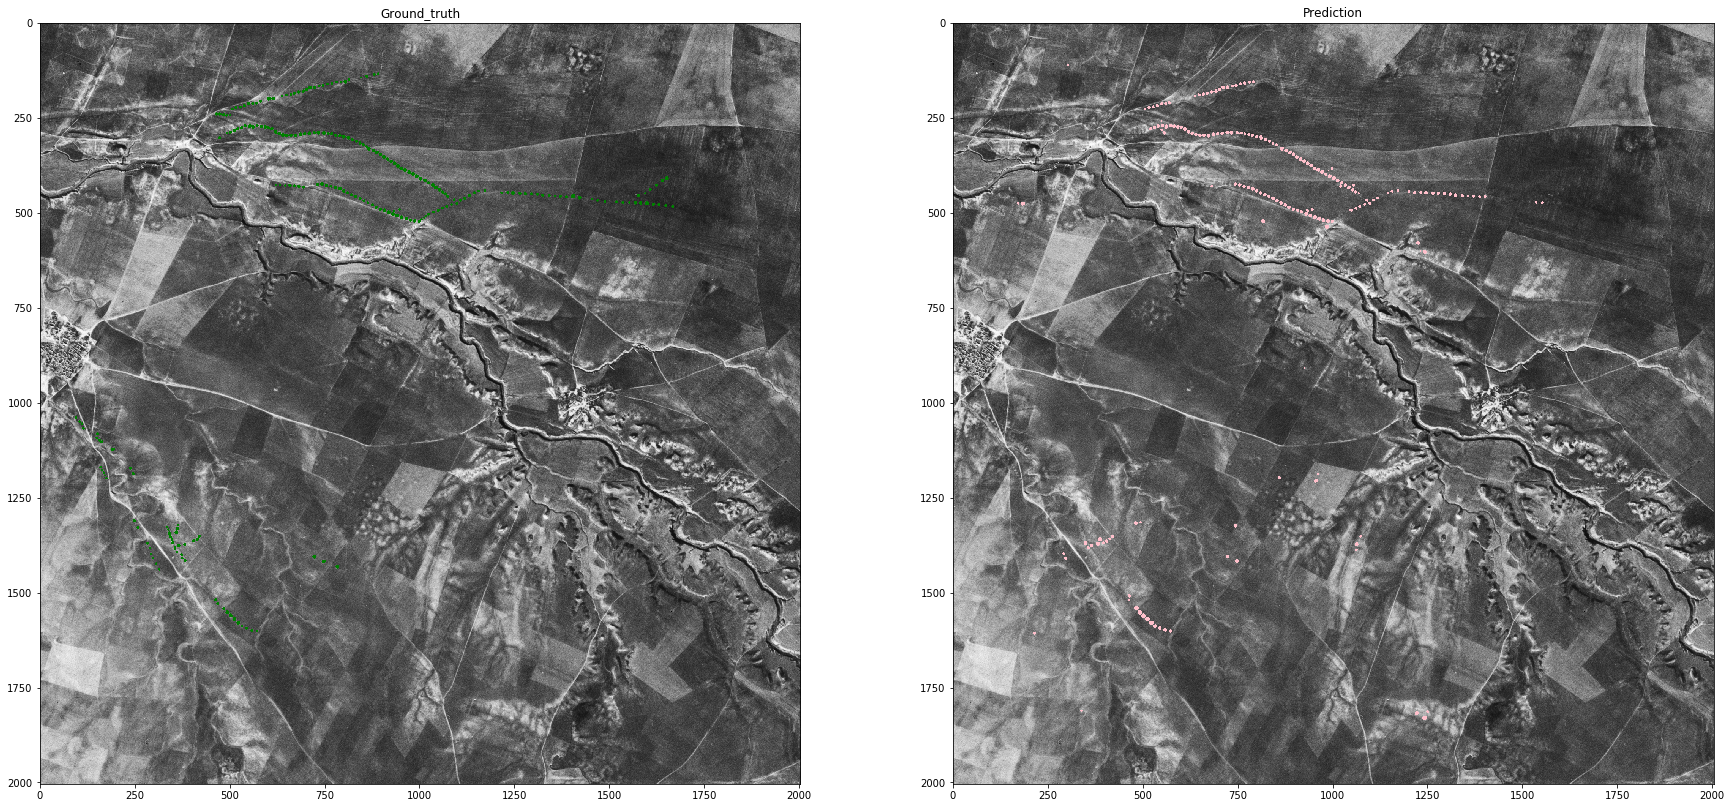

In [9]:
plt.figure(figsize=(30,30))
plt.subplot(121)
plt.imshow(image_nda, cmap=plt.cm.gray)
plt.imshow(label_nda, alpha=1, cmap=cmap_green)
plt.title('Ground_truth')
plt.subplot(122)
plt.title('Prediction')
plt.imshow(image_nda, cmap=plt.cm.gray)
plt.imshow(pred_nda, alpha=1, cmap=cmap_pink)

In [10]:
def fit_circles(label_nda):
    hough_radii = np.arange(1, 2, 1)
    hough_res = hough_circle(label_nda, hough_radii)
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=1000)

    label_circles = np.zeros(label_nda.shape)
    for center_y, center_x, radius in zip(cy, cx, radii):
        #label_circles[center_y-1:center_y, center_x-1:center_x] = 1
        circy, circx = circle_perimeter(center_y, center_x, radius)
        label_circles[circy, circx] = 1
    label_circles = np.ma.masked_where(label_circles== 0, label_circles)
    return cx, cy,radii, label_circles

In [11]:
cx, cy,_, label_circles = fit_circles(label_nda)

In [12]:
cx_pred, cy_pred,_, label_circles_pred = fit_circles(pred_nda)

In [13]:
centers = np.vstack((cx,cy)).T
centers_preds = np.vstack((cx_pred,cy_pred)).T

In [14]:
print(len(cx))
print(len(cx_pred))

231
181


In [15]:
distances = cdist(centers, centers_preds)

In [16]:
min_distance = 10
tp_points = np.min(distances, axis=0) < min_distance
tp = np.sum(tp_points)
fp = len(cx_pred) - tp
fn = len(cx) - tp

In [17]:
precision = (tp)/(tp + fp)
recall = (tp)/(tp + fn)
f1 = (2*tp)/ (2*tp + fp +fn)
print('tp: {}, fp: {}, fn: {}'.format(tp, fp, fn))
print('precision: {0:0.2f}, recall: {1:0.2f}, f1: {2:0.2f}'.format(precision, recall, f1))

tp: 149, fp: 32, fn: 82
precision: 0.82, recall: 0.65, f1: 0.72


In [21]:
cx_pred_tp = cx_pred[tp_points]
cy_pred_tp = cx_pred[tp_points]

In [22]:
label_circles_tp = np.zeros(label_nda.shape)
for center_y, center_x in zip(cy_pred, cx_pred):
    #label_circles[center_y-1:center_y, center_x-1:center_x] = 1
    circy, circx = circle_perimeter(center_y, center_x, 2)
    label_circles_tp[circy, circx] = 1

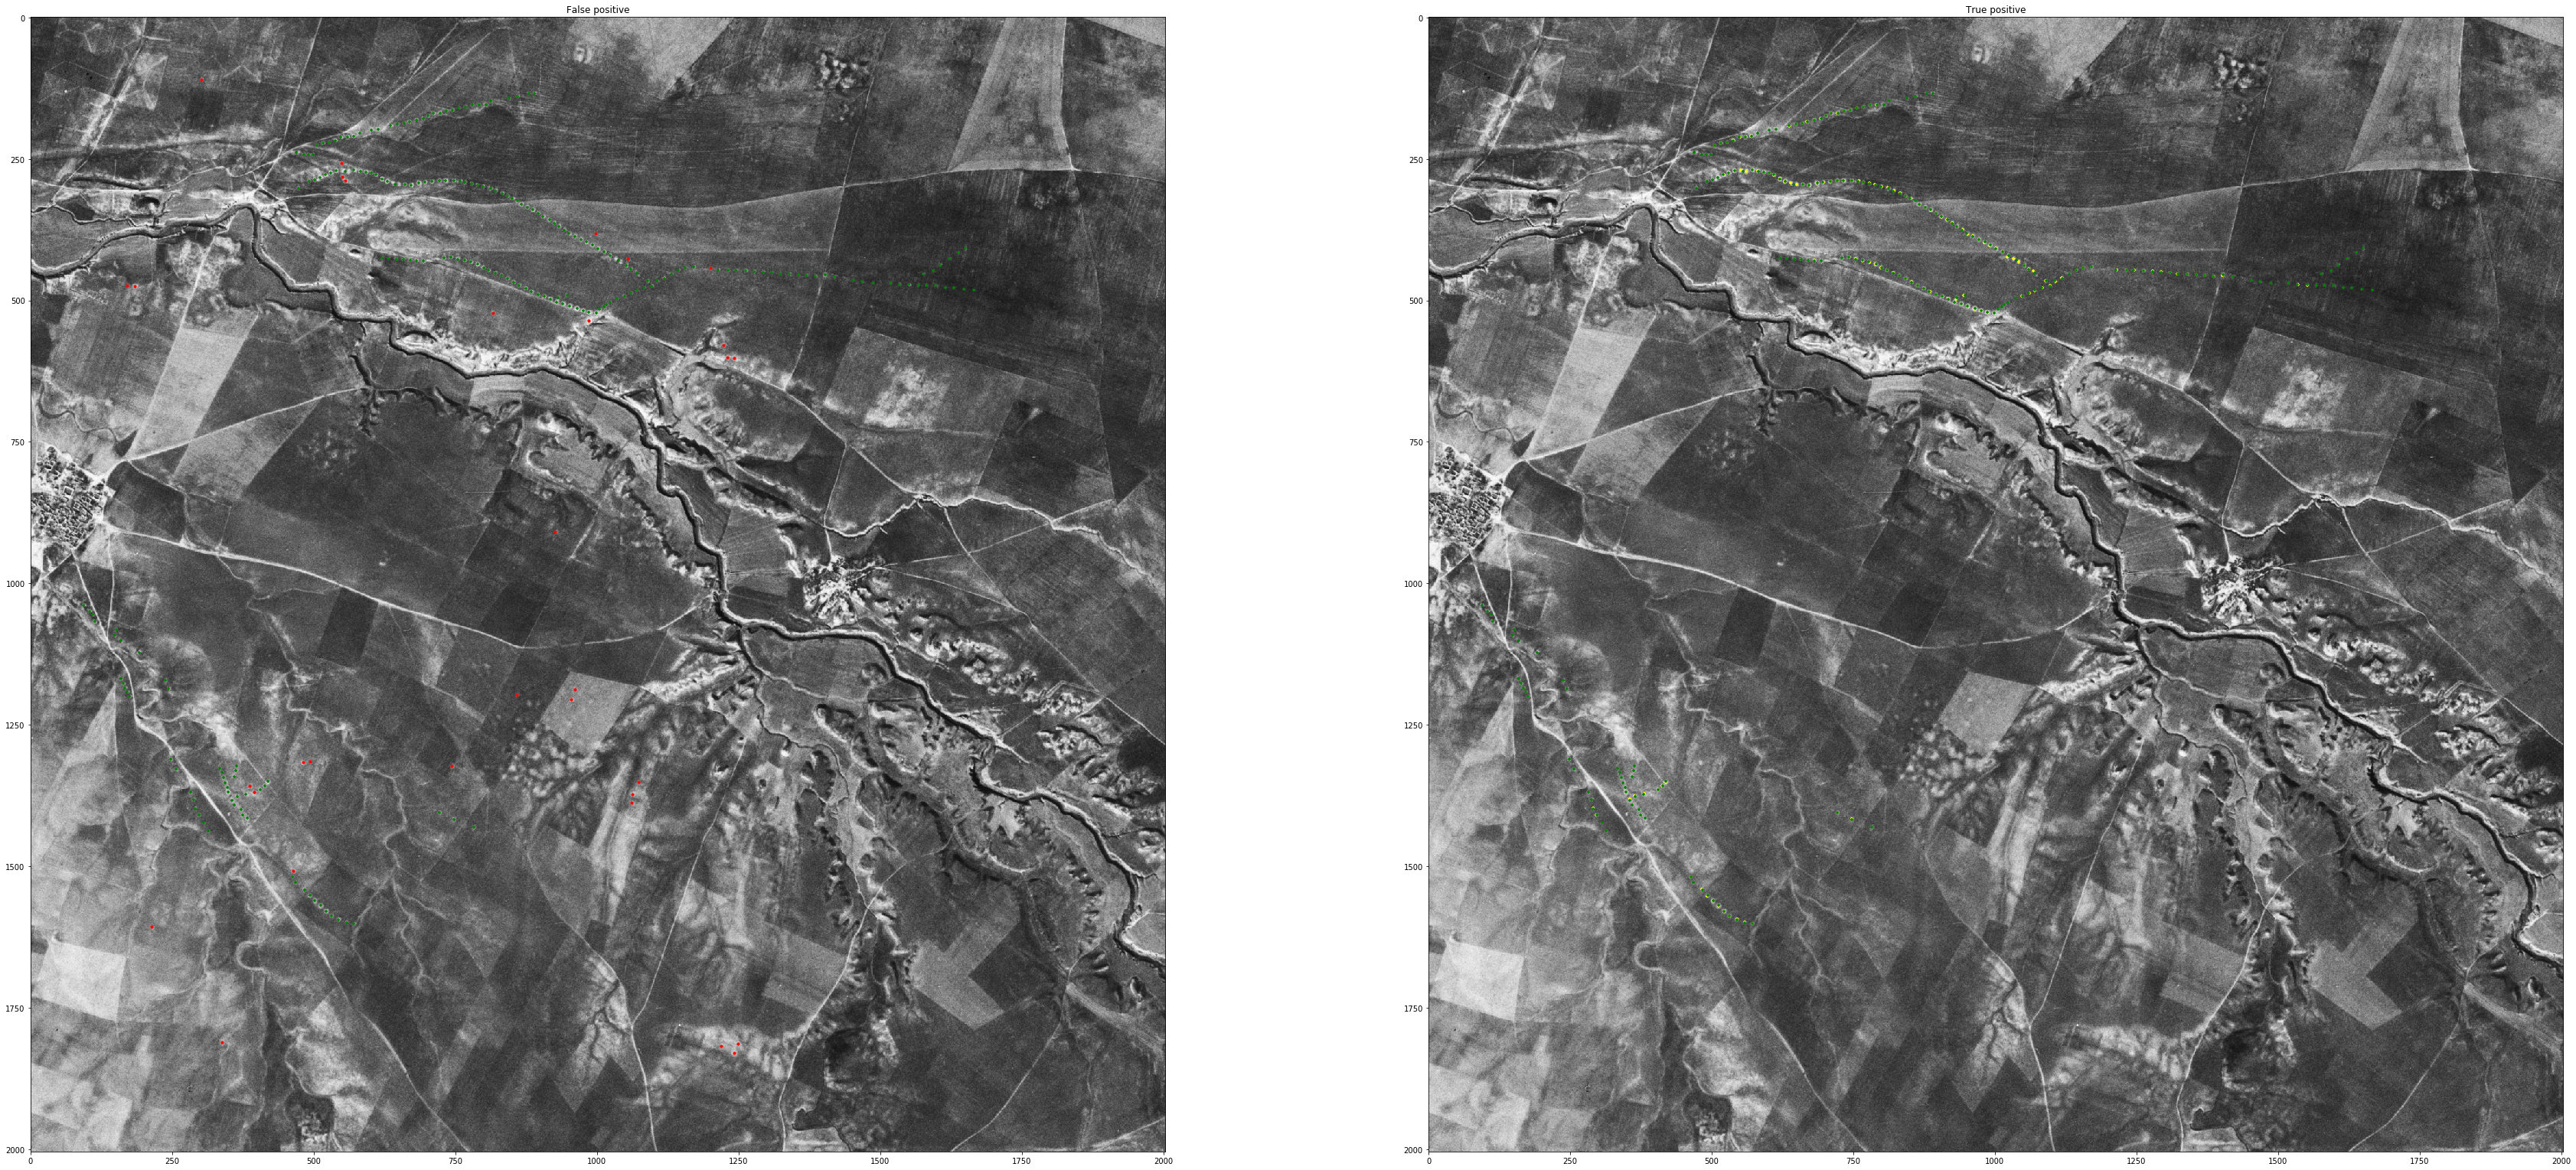

In [23]:
plt.figure(figsize=(60,60))
plt.subplot(221)
plt.imshow(image_nda, cmap=plt.cm.gray)
plt.scatter(cx_pred[np.invert(tp_points)],cy_pred[np.invert(tp_points)], s=10, marker="o",color='red')
plt.scatter(cx,cy, s=10, marker="+",color='green')
plt.title('False positive')
plt.subplot(222)
plt.title('True positive')
plt.imshow(image_nda, cmap=plt.cm.gray)
plt.scatter(cx_pred[tp_points],cy_pred[tp_points], s=15, marker="+", color='yellow')
plt.scatter(cx,cy, s=10, marker="+",color='green')

In [304]:
class CheckResults:
    def __init__(self, image, ground_truth_label, prediction_label, cx, cy, cx_pred, cy_pred, tp_points):
        self.image = image
        self.ground_truth_label = ground_truth_label
        self.prediction_label = prediction_label
        self.cx = cx
        self.cy = cx
        self.cx_pred = cx_pred
        self.cy_pred = cy_pred
        self.tp_points = tp_points
        #
        shape = ground_truth_label.shape
        self.x_slider = widgets.IntRangeSlider(min=0,max=shape[0], step=5)
        self.y_slider = widgets.IntRangeSlider(min=0, max=shape[1], step=5)
        vbox = widgets.HBox([self.x_slider, self.y_slider])
        interactive(self.update_plots,x_range=self.x_slider, y_range=self.y_slider)
        box_layout = Layout(align_items='stretch',
                            width='100%',
                            height='100%'
                            )
        self.output = widgets.Output(layout=box_layout)
        self.vbox = widgets.VBox([vbox, self.output])


    def update_plots(self, x_range, y_range):
        with self.output:
            plt.figure(figsize=(15,15))
            plt.subplot(221)
            plt.imshow(self.image, cmap=plt.cm.gray)
            plt.scatter(self.cx_pred[np.invert(self.tp_points)],self.cy_pred[np.invert(self.tp_points)], s=3, marker="+",color='red')
            plt.title('False positive')
            plt.subplot(222)
            plt.title('True positive')
            plt.imshow(self.image, cmap=plt.cm.gray)
            plt.scatter(self.cx_pred[self.tp_points],self.cy_pred[self.tp_points], s=3, marker="+", color='green')
            plt.subplot(223)
            plt.imshow(self.image[x_range[0]:x_range[1], y_range[0]:y_range[1]], cmap=plt.cm.gray)
            plt.title('False positive')
            pred_filter_cx = self.cx_pred> y_range[0]
            pred_filter_cx = self.cx_pred< y_range[1]
            pred_filter_cx = self.cx_pred> 0
            pred_filter_cy = self.cy_pred> x_range[0]
            pred_filter_cy = self.cy_pred< x_range[1]
            pred_filter_cy = self.cy_pred> 0
            pred_filter_fp = np.logical_and(pred_filter_cx, pred_filter_cy, np.invert(self.tp_points))
            plt.scatter(self.cx_pred[pred_filter_fp],self.cy_pred[pred_filter_fp], s=3, marker="+",color='red')
            plt.subplot(224)
            plt.title('True positive')
            plt.imshow(self.image, cmap=plt.cm.gray)
            plt.scatter(self.cx_pred[self.tp_points],self.cy_pred[self.tp_points], s=3, marker="+", color='green')
            clear_output(wait=True)
            plt.show()

In [305]:
ch = CheckResults(image_nda, label_nda, pred_nda, cx, cy, cx_pred, cy_pred, tp_points)

In [306]:
ch.vbox

VBox(children=(HBox(children=(IntRangeSlider(value=(501, 1503), description='x_range', max=2004, step=5), IntRangeSlider(value=(501, 1503), description='y_range', max=2004, step=5))), Output(layout=Layout(align_items='stretch', height='100%', width='100%'))))